In [109]:
import mysql.connector
from typing import List
import matplotlib.pyplot as plt
import datetime

In [110]:
class DtoClampPoint:
    def __init__(self, C1ACRMS, C1TrueRMS, Time):
        self.C1ACRMS = C1ACRMS
        self.C1TrueRMS = C1TrueRMS
        self.Time = Time

class DtoPlugPoint:
    def __init__(self, Watt, Current, Voltage, Ip, Time,React, Apparent ,PowFactor):
        self.Watt = Watt
        self.Current = Current
        self.Voltage = Voltage
        self.Ip = Ip
        self.Time = Time
        self.React = React
        self.Apparent = Apparent
        self.PowerFactor = PowFactor

class TimeSeries:
    def __init__(self):
        self.Samples = []

class Sample:
    def __init__(self, CpuUtilization, ElapsedTime, AdditionalMetadata, 
                 DramEnergyInJoules, GpuEnergyInJoules, PackageTemperature, 
                 ProcessorPowerWatt, CpuEnergyInJoules,time):
        self.CpuUtilization = CpuUtilization
        self.ElapsedTime = ElapsedTime
        self.AdditionalMetadata = AdditionalMetadata
        self.DramEnergyInJoules = DramEnergyInJoules
        self.GpuEnergyInJoules = GpuEnergyInJoules
        self.PackageTemperature = PackageTemperature
        self.ProcessorPowerWatt = ProcessorPowerWatt
        self.CpuEnergyInJoules = CpuEnergyInJoules
        self.time = time



In [111]:
def FetchClampResults(startTime: datetime, endTime: datetime) -> List[DtoClampPoint]:
    points = []
    config = {"host": "mysql47.unoeuro.com", "user": "stemlevelup_com", "password": "ez3rnBAx92p4", "database": "stemlevelup_com_db"}

    with mysql.connector.connect(**config) as connection:

        formattedStartTime = startTime.strftime("%Y-%m-%d %H:%M:%S.%f")
        formattedEndTime = endTime.strftime("%Y-%m-%d %H:%M:%S.%f")

        cursor = connection.cursor()
        query = "SELECT * FROM Measurements WHERE time BETWEEN %s AND %s"
        cursor.execute(query, (formattedStartTime, formattedEndTime))

        for (id,C1TrueRMS, C1ACRMS, time) in cursor:
            points.append(DtoClampPoint(C1ACRMS, C1TrueRMS, time))

        cursor.close()

        if len(points) == 0:
            raise ClampQueryFoundNoPointsException
    return points

def CalculateTimeSeries(startTime: datetime, endTime: datetime) -> TimeSeries:
    results = FetchClampResults(startTime,endTime)
    timeSeries = TimeSeries()
    elapsedMilliseconds = (endTime - startTime).total_seconds() * 1000
    avgRate = len(results) / (elapsedMilliseconds / 1000)

    for item in results:
        test = ConvertToJoule(item.C1TrueRMS , len(results))/avgRate
        timeSeries.Samples.append(Sample(
            CpuEnergyInJoules=test,
            ElapsedTime=(item.Time - startTime).total_seconds() * 1000,
            AdditionalMetadata={},
            CpuUtilization=0,
            DramEnergyInJoules=0,
            GpuEnergyInJoules=0,
            PackageTemperature=0,
            ProcessorPowerWatt=0,
            time = item
        ))

    return timeSeries

def ConvertToJoule(measurement: float, count: int) -> float:
    miliVolt = measurement * 1000 # Converts from volt to milliJoule
    A = miliVolt / 100 # Uses the specific conversion ratio
    joule = A * 230
    return joule


In [112]:
def FetchPlugResults(startTime: datetime, endTime: datetime) -> List[DtoPlugPoint]:
    points = []
    config = {"host": "mysql47.unoeuro.com", "user": "stemlevelup_com", "password": "ez3rnBAx92p4", "database": "stemlevelup_com_db"}

    with mysql.connector.connect(**config) as connection:
        formattedStartTime = startTime.strftime("%Y-%m-%d %H:%M:%S.%f")
        formattedEndTime = endTime.strftime("%Y-%m-%d %H:%M:%S.%f")

        cursor = connection.cursor()
        query = "SELECT * FROM power_usage WHERE time BETWEEN %s AND %s AND Ip = %s"
        cursor.execute(query, (formattedStartTime, formattedEndTime, "192.168.1.182"))

        for (id, Watt, Current, Voltage, Ip, time, React, Apparent ,PowFactor) in cursor:
            points.append(DtoPlugPoint(Watt, Current, Voltage, Ip, time,React, Apparent ,PowFactor))

        cursor.close()

        if len(points) == 0:
            raise PlugQueryFoundNoPointsException

    return points


def convert_watt_to_joule(watt, count, duration):
    avg_rate = count / (duration / 1000)
    return watt / avg_rate

def fetch_results(start_time, end_time):
    results = FetchPlugResults(start_time, end_time)
    elapsedMilliseconds = (end_time-start_time).total_seconds() * 1000
    time_series = TimeSeries()
    for item in results:
        time_series.Samples.append(Sample(
            CpuEnergyInJoules= convert_watt_to_joule(item.Watt, len(results), elapsedMilliseconds),
            ElapsedTime = (item.Time - start_time).total_seconds() * 1000,
            AdditionalMetadata={"PowerFactor":item.PowerFactor},
            CpuUtilization=0,
            DramEnergyInJoules=0,
            GpuEnergyInJoules=0,
            PackageTemperature=0,
            ProcessorPowerWatt=0,
            time = item.Time
            ))
    return time_series


2023-05-20 07:00:00
2023-05-21 07:00:00
828886


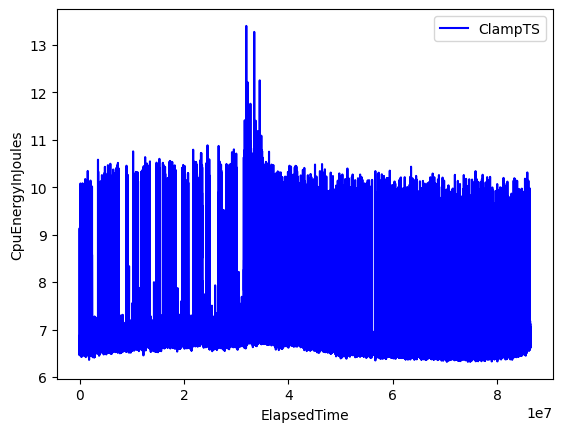

In [113]:

current_time = datetime.datetime.now()
format_string = "%Y-%m-%d %H:%M:%S.%f"
# date_string = "2023-03-30 10:30:54.0" #plug
# Sdate_string = "2023-04-17 13:55:15.561" #clamp
# Edate_string = "2023-04-18 13:55:15.561" #clamp

Sdate_string = "2023-05-21 7:00:00.000" #clamp
Edate_string = "2023-05-22 7:00:00.000" #clamp

# start_time = current_time - datetime.timedelta(hours=24*3)
# end_time = current_time - datetime.timedelta(hours=15)
start_time = datetime.datetime.strptime(Sdate_string, format_string)
end_time = datetime.datetime.strptime(Edate_string, format_string)
# start_time = start_time - datetime.timedelta(seconds=10)
# end_time = start_time + datetime.timedelta(hours=24*3 -2)
print(start_time)
print(end_time)
ClampTS =  CalculateTimeSeries(start_time,end_time)
# PlugTS = fetch_results(start_time, end_time)
print(len(ClampTS.Samples))
# print(len(PlugTS.Samples))
import matplotlib.pyplot as plt

# extract data for ClampTS
clamp_x = [s.ElapsedTime for s in ClampTS.Samples]
clamp_y = [s.CpuEnergyInJoules for s in ClampTS.Samples]
clamp_PF = [s.CpuEnergyInJoules for s in ClampTS.Samples]
clamp_time = [s.time for s in ClampTS.Samples] 

# extract data for PlugTS
# plug_x = [s.ElapsedTime for s in PlugTS.Samples]
# plug_y = [s.CpuEnergyInJoules for s in PlugTS.Samples]
# plug_PF = [s.CpuEnergyInJoules for s in PlugTS.Samples]
# plug_time = [s.time for s in PlugTS.Samples] 
# print(len(plug_y))
# print(len(clamp_y))

# plot the data
plt.plot(clamp_x, clamp_y, color='blue', label='ClampTS')
# plt.plot(plug_x, plug_y, color='green', label='PlugTS')


# add axis labels and legend
plt.xlabel('ElapsedTime')
plt.ylabel('CpuEnergyInJoules')
plt.legend()

# show the plot
plt.show()
# print(plug_PF)

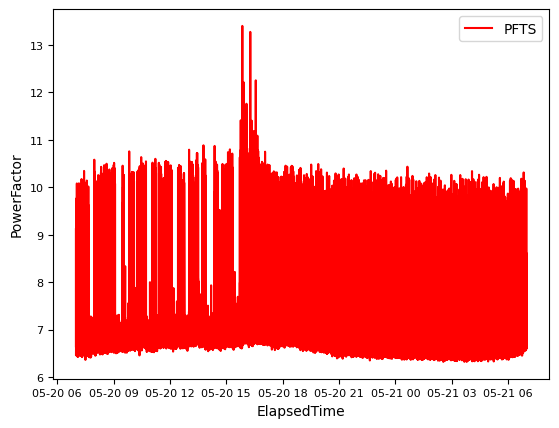

In [114]:
group_size = 1
grouped_sums = []
filtered = clamp_PF
# filtered = plug_PF

for i in range(0, len(filtered), group_size):
    group_sum = sum(filtered[i:i+group_size])
    grouped_sums.append(group_sum)

grouped_sums = grouped_sums[:-1]
group_n = list(range(0,len(grouped_sums)))

duration = end_time - start_time
interval_length = duration / len(group_n)

span = []
for i in range(len(group_n)):
    span_start = start_time + i * interval_length
    span_end = span_start + interval_length
    span.append(span_end)

plt.plot(span,grouped_sums, color='red', label='PFTS')
# add axis labels and legend
plt.xlabel('ElapsedTime')
plt.ylabel('PowerFactor')
plt.legend()

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# show the plot
plt.show()
# print(plug_PF)

In [115]:

samples = ClampTS.Samples

# print(samples[0].time.Time)
# samples = PlugTS.Samples
day_night = []

# Create datetime objects for the time thresholds
night_start = datetime.time(hour=0)
day_start = datetime.time(hour=5)
day_end = datetime.time(hour=15)

for point in samples:
    # Determine whether the sample is "night" or "day"
    # if point.Time.time() < night_start or point.time.time() >= day_end:
    #     point_label = "night"
    # elif point.time.time() >= day_start and point.Time.time() < day_end:
    #     point_label = "day"
    # else:
    #     point_label = "night"  # Error handling, if needed

    if point.time.Time.time() < night_start or point.time.Time.time() >= day_end:
        point_label = "night"
    elif point.time.Time.time() >= day_start and point.time.Time.time() < day_end:
        point_label = "day"
    else:
        point_label = "night"  # Error handling, if needed

    # Add the sample and its label to the list
    day_night.append((point, point_label))

Day = [x[0] for x in day_night if x[1] == "day"]
Night = [x[0] for x in day_night if x[1] == "night"]

print(len(Day))
print(len(Night))

344683
484203


In [116]:
if(0):
    plt.plot([x.time for x in Day],[x.CpuEnergyInJoules for x in Day], color='red', label='PFTS')
    # plt.plot([x.time for x in Day],[x.CpuEnergyInJoules for x in Day], color='red', label='PFTS')

    # add axis labels and legend
    plt.xlabel('Time')
    plt.ylabel('PowerFactor')
    plt.legend()

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # show the plot
    plt.show()
    print(plug_PF)

    plt.plot([x.time for x in Night],[x.CpuEnergyInJoules for x in Night], color='red', label='PFTS')
    # plt.plot([x.time for x in Night],[x.CpuEnergyInJoules for x in Night], color='red', label='PFTS')

    # add axis labels and legend
    plt.xlabel('Time')
    plt.ylabel('PowerFactor')
    plt.legend()

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # show the plot
    plt.show()
    # print(plug_PF)

In [117]:
def GroupySum(filtered, group_size):
    grouped_sums = []
    result = []
    for i in range(0, len(filtered), group_size):
        group_sum = sum(filtered[i:i+group_size])
        grouped_sums.append(group_sum)
    for i in range(len(grouped_sums)):
        if(i == len(grouped_sums)-1):
            if((len(filtered)%group_size) != 0):
                result.append(grouped_sums[i]/(len(filtered)%group_size))
            else:
                result.append(grouped_sums[i]/group_size)
        else:
            result.append(grouped_sums[i]/group_size)

    group_n = list(range(0,len(result)))
    return (result, group_n)

def GroupyMin(filtered, group_size):
    grouped_sums = []
    result = []
    for i in range(0, len(filtered), group_size):
        group_sum = min(filtered[i:i+group_size])
        grouped_sums.append(group_sum)


    group_n = list(range(0,len(result)))
    return (grouped_sums, group_n)

def RunningWindow(lst,window_size):
    windowed_lst = []
    for i in range(len(lst) - window_size + 1):
        windowed_lst.append(lst[i:i+window_size])

    avgWindows = [sum(x)/window_size for x in windowed_lst]
    return (avgWindows,list(range(0,len(avgWindows))))

def RollingAvg(lst,window):
    rolling_avg = []
    for i in range(len(lst) - window + 1):
        window_sum = sum(lst[i:i+window])
        rolling_avg.append(window_sum / window)

    return (rolling_avg,list(range(0,len(rolling_avg))))

def ExpSmoothing(lst, window):
    alpha = 2 / (window + 1) # Calculate the smoothing factor
    smoothed_lst = [lst[0]] # Initialize the smoothed list with the first value

    for i in range(1, len(lst)):
        smoothed_value = alpha * lst[i] + (1 - alpha) * smoothed_lst[-1]
        smoothed_lst.append(smoothed_value)

    return (smoothed_lst,list(range(0,len(smoothed_lst))))

from scipy.signal import butter, filtfilt, find_peaks
import numpy as np
def LowPassFilter(data, cutoff_freq, sampling_freq, order=5):
    nyquist_freq = 0.5 * sampling_freq
    normal_cutoff_freq = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff_freq, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return (filtered_data,list(range(0,len(filtered_data))))

def remove_peaks(data, peak_height=None, peak_distance=None):

    peak_indices, _ = find_peaks(data, height=peak_height, distance=peak_distance)

    # Remove the peaks from the data
    filtered_data = np.delete(data, peak_indices)

    return (filtered_data, list(range(0,len(filtered_data))))

def valley_subsample(data, n):
    # Smooth the data using a moving average filter
    smoothed_data = np.convolve(data, np.ones(3)/3, mode='same')

    # Find the valleys in the smoothed data
    valley_indices, _ = find_peaks(-smoothed_data)

    # Select every nth valley index
    subsampled_indices = valley_indices[::n]

    # Add the first and last indices to ensure that the entire time series is included
    subsampled_indices = np.concatenate(([0], subsampled_indices, [len(data)-1]))

    # Sort the indices and select the corresponding data points
    subsampled_data = data[np.sort(subsampled_indices)]

    return (subsampled_data, list(range(0,len(subsampled_data))))


In [118]:
10%15

10

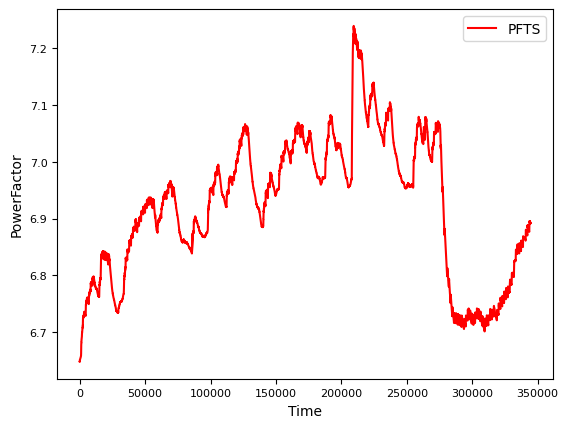

Slope: 21448.756497625207
Y-intercept: 23873.841917405807


In [119]:
from sklearn.linear_model import LinearRegression

DayVals,DayN = valley_subsample(np.array([x.CpuEnergyInJoules for x in Day]),60)
DayVals,DayN = ExpSmoothing([x.CpuEnergyInJoules for x in Day],9000)
xD = DayVals
yD = list(range(0,len(DayVals)))

model = LinearRegression()

model.fit([[i] for i in xD], yD)

plt.plot(yD,xD, color='red', label='PFTS')

# add axis labels and legend
plt.xlabel('Time')
plt.ylabel('PowerFactor')
plt.legend()

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# show the plot
plt.show()

print("Slope:", model.coef_[0])
print("Y-intercept:", model.intercept_)

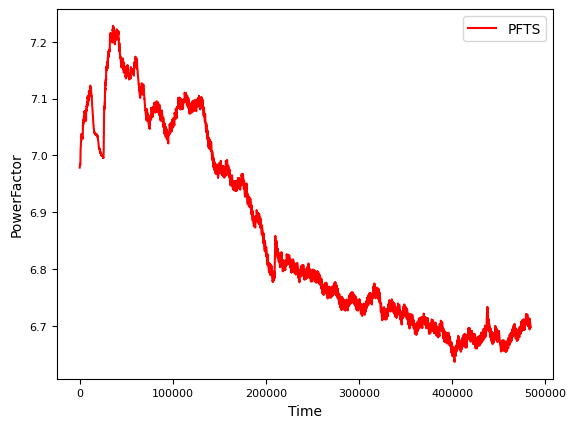

Slope: -765099.5118000085
Y-intercept: 5491492.874953443


In [120]:
NightVals,NightN = valley_subsample(np.array([x.CpuEnergyInJoules for x in Night]), 60)
NightVals,NightN = ExpSmoothing([x.CpuEnergyInJoules for x in Night],9000)

xN = NightVals
yN = list(range(0,len(NightVals)))

model = LinearRegression()

model.fit([[i] for i in xN], yN)

plt.plot(yN,xN, color='red', label='PFTS')

# add axis labels and legend
plt.xlabel('Time')
plt.ylabel('PowerFactor')
plt.legend()

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# show the plot
plt.show()

print("Slope:", model.coef_[0])
print("Y-intercept:", model.intercept_)

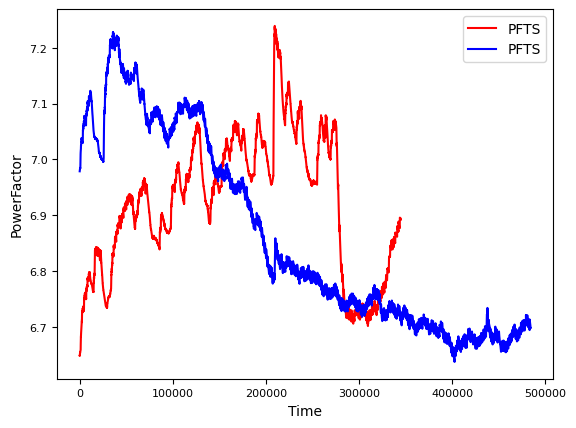

In [121]:
plt.plot(yD,xD, color='red', label='PFTS')
plt.plot(yN,xN, color='blue', label='PFTS')

# add axis labels and legend
plt.xlabel('Time')
plt.ylabel('PowerFactor')
plt.legend()

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# show the plot
plt.show()

In [122]:
Every10IndexDay = [x for x in yD if x%1000 == 0]
Every10IndexNight = [x for x in yN if x%1000 == 0]

Every10ValueDay = []
Every10ValueNight = []

for i in Every10IndexDay:
    Every10ValueDay.append(xD[i])
for i in Every10IndexNight:
    Every10ValueNight.append(xN[i])

combined = Every10ValueDay[:-1] + Every10ValueNight[1:]
print("the split is in index: "+str(len(Every10IndexDay)))

printable = []
for i in range(0, len(combined)):
    strVal = f"({str(i)},{combined[i]})"
    printable.append(strVal)

the split is in index: 345


In [123]:
results = "".join(printable)

In [124]:
results

'(0,6.647673201412657)(1,6.658181017402556)(2,6.705476100380886)(3,6.7290672089246755)(4,6.732934244287217)(5,6.7518596079495925)(6,6.758619902406849)(7,6.755559066260613)(8,6.774570128771825)(9,6.786736203683153)(10,6.794997140338782)(11,6.7920192189255655)(12,6.780374779658058)(13,6.776130262786925)(14,6.765570258382433)(15,6.770640852750252)(16,6.794118006097006)(17,6.834874872053677)(18,6.841205796078045)(19,6.827322164037587)(20,6.833875672000401)(21,6.831749176441804)(22,6.835129183336666)(23,6.820759069151449)(24,6.7944449392605435)(25,6.771648766364668)(26,6.7593616602229085)(27,6.748545830896733)(28,6.737489417828482)(29,6.734325683901013)(30,6.743698235932887)(31,6.752773627547725)(32,6.754500205070593)(33,6.76052069520421)(34,6.793175217649014)(35,6.814164804735136)(36,6.826144168488002)(37,6.842026752278755)(38,6.8583636048976615)(39,6.855949729496136)(40,6.871902945337573)(41,6.881949662095035)(42,6.878092519865227)(43,6.895604010601674)(44,6.88439594940878)(45,6.890882877

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


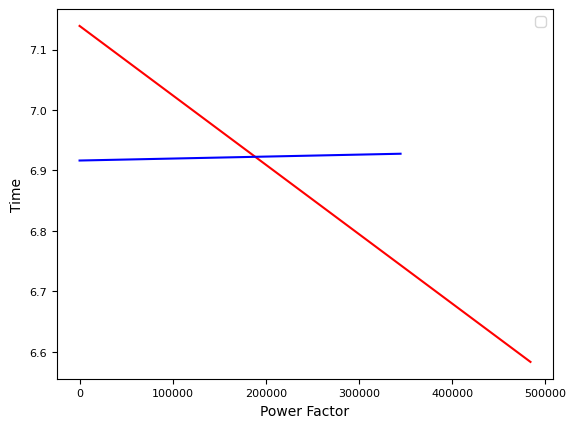

In [125]:
import numpy as np
import matplotlib.pyplot as plt


# plot data points
# plt.scatter(yN, xN, color='red', label='Night')
# plt.scatter(yD, xD, color='blue', label='Day')

# plot linear regression lines
coeffN = np.polyfit(yN, xN, 1)
plt.plot(yN, np.polyval(coeffN, yN), color='red')

coeffD = np.polyfit(yD, xD, 1)
plt.plot(yD, np.polyval(coeffD, yD), color='blue')

# add axis labels and legend
plt.xlabel('Power Factor')
plt.ylabel('Time')
plt.legend()

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# show the plot
plt.show()

In [126]:
import numpy as np
ClampMean = []
PlugMean = []
stepSize = 10000
for i in range(0,len(clamp_y),stepSize):
    res = np.mean(clamp_y[i:i+stepSize])
    ClampMean.append(res)
for i in range(0,len(plug_y),stepSize):
    res = np.mean(plug_y[i:i+stepSize])
    PlugMean.append(res)

plt.plot(ClampMean, color='blue', label='ClampTS')
plt.plot(PlugMean, color='green', label='PlugTS')
print(ClampMean)
print(PlugMean)
# add axis labels and legend
plt.xlabel('ElapsedTime')
plt.ylabel('CpuEnergyInJoules')
plt.legend()

# show the plot
plt.show()

NameError: name 'plug_y' is not defined